# Drought analysis

**This notebook requires netcdf files which can be created by running the other two notebooks first: *drought_indices.ipynb*, and *sri_ssi_indices.ipynb*.**

We start off with loading the required R packages (and installing them if they are not found). Before running the script, a folder to house the R library should be created and given in *mypackagepath* variable.

In [2]:
mypackagepath = "/home/jovyan/work/workspace/rlib"
.libPaths(c(mypackagepath,.libPaths()))
load_libs <- function(packages) {
    for(package in packages) {
        test <- require(package, character.only=TRUE)
        if(!test) {
            install.packages(package)
            library(package)
        }
    }
}
load_libs(c("doParallel", "foreach", "raster", "ncdf4", "tibble", "arules", "igraph"))

Loading required package: doParallel
Loading required package: foreach
Warning message:
“package ‘foreach’ was built under R version 3.5.3”Loading required package: iterators
Loading required package: parallel
Loading required package: raster
Loading required package: sp
Loading required package: ncdf4
Warning message:
“package ‘ncdf4’ was built under R version 3.5.3”Loading required package: tibble
Warning message:
“package ‘tibble’ was built under R version 3.5.3”Loading required package: arules
Warning message:
“package ‘arules’ was built under R version 3.5.3”Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: igraph
Warning message:
“package ‘igraph’ was built under R version 3.5.3”
Attaching package: ‘igraph’

The following object is masked from ‘package:arules’:

    union

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objec

## Define required functions

Drought characteristics function (drought_char_par()) identifies drought events based on a threshold, and calculates duration, intensity and severity of the drought event. The functions works on a cell-by-cell basis, and does not consider neighbouring cells.

In [3]:
drought_char_par <- function(d_mat, threshold, ncores) {
    
    d_mat[is.na(d_mat)] <- 0
    
    # Detect drought events and calculate duration, intensity, and severity
    
    registerDoParallel(ncores)
    #print("finding drought events and calculating characteristics..")
    events <- foreach(lon = 1:dim(d_mat)[1],
                      .packages = c("foreach")) %dopar% {
        event <- list()
        # ev <- 1
        # dur <- 0
        # start <- NA
        # end <- NA
        
        event <- foreach(lat = 1:dim(d_mat)[2]) %do% {
            eventout <- list()
            ev <- 1
            dur <- 0
            start <- NA
            end <- NA
            for(t in 1:dim(d_mat)[3]) {
                drought <- d_mat[lon,lat,t] < threshold
                
                if(drought) {
                    if(dur == 0) {
                        start <- t
                    } 
                    dur <- dur + 1
                } else {
                    if(dur > 0) {
                        end <- t-1
                        
                        # intensity, severity
                        dind <- d_mat[lon,lat,start:end]
                        int <- mean(dind)
                        sev <- sum(dind)
                        
                        # store and reset
                        char <- c(x = lon,
                                  y = lat,
                                  Start = start,
                                  End = end, 
                                  Duration = dur,
                                  Intensity = int,
                                  Severity = sev)
                        eventout[[ev]] <- char
                        ev <- ev+1
                        start <- end <- NA
                        dur <- 0
                    } 
                }
            }
            eventout <- do.call(rbind, eventout)
            return(eventout)
        }
        #remove empty
        remove <- which(unlist(lapply(event, function(x) length(x) == 0)))
        event <- event[-remove]
        event <- do.call(rbind, event)
        return(event)
    }
    stopImplicitCluster()
    
    #print("preparing output..")
    #remove <- which(unlist(lapply(events, function(x) length(x) == 0)))
    #events <- events[-remove]
    events <- do.call(rbind, events)
    events <- as_tibble(events)
    
    return(events)
}
                          

drought_clumps() creates drought events by identifying contiguous areas of a drought index, based on a threshold, for every timestep in the data. It returns a raster stack with one layer for each timestep.

In [4]:
drought_clumps <- function(drought_index,threshold,lat,lon, time) {
    ### Function reads in drought index array(e.g. SPI3), threshold for drought events
    ### and latitudes,longitudes and time. 
    ### Order of drought index array dimensions is [lon, lat, time]
    
    ### returns: raster stack of geographical clumps of areas with simultaneous drought event. 
    
    # Remove values that are above drought threshold
    #timeit <- Sys.time()
    drought_index[drought_index>= threshold ]<-NA
    min_lat <- min(lat)
    max_lat <- max(lat)
    min_lon<- min(lon)
    max_lon <- max(lon)

    # rasterize arrays and apply clump-function to the list of rasters
    drought_list <- apply(X=drought_index, MARGIN = 3, 
                         FUN = function(x) {raster(x,xmn = min_lon, xmx = max_lon, ymn=min_lat, ymx = max_lat)})

    
    drought_clumps <- lapply(drought_list, clump)

    # stack rasters and apply timesteps as layer names
    class(drought_clumps)
    drought_clumps <- stack(drought_clumps)
    names(drought_clumps) <- time
    
    #print(paste(c("clumping takes", Sys.time() -timeit, "seconds"), collapse=" "))
    return (drought_clumps)
}

transactions_from_clumps() identifies overlap between drought events of different indices, and creates a transaction list required for association rule mining. Can be modified by 

In [5]:
transactions_from_clumps <- function(clump_list, min_cells, min_share, ncores) {
        
    clumps <- clump_list
    system.time({
    registerDoParallel(ncores)
    message("Starting analysis..")
    
    #do comparisons with each drought type
    transactions <- foreach(source = 1:length(clumps)) %do% {
        
        names <- names(clumps)
        
        # we do this for every timestep in source 
        timesteps <- foreach(tstep = 1:nlayers(clumps[[source]])) %do% {
            vals <- values(clumps[[source]][[tstep]])
            uniq <- unique(vals)
            uniq <- uniq[-(is.na(uniq))]
            
            # for every drought event in source @ tstep
            event <- foreach(ev = 1:length(uniq),
                             .packages = "raster") %dopar% {
                cellind <- which(vals == uniq[ev])
                
                trans_mat <- rep(FALSE, length(clumps))
                names(trans_mat) <- names
                trans_mat[source] <- TRUE
                
                # compare to every other drought type
                for(comp in 1:length(clumps)) {
                    # comparing to the same drought type makes no sense
                    if(comp == source) next
                    
                    compvals <- values(clumps[[comp]][[tstep]])
                    uniqcomp <- unique(compvals[cellind])
                    uniqcomp <- uniqcomp[!is.na(uniqcomp)]
                    
                    
                    test <- length(uniqcomp) == 0
                    if(!test) {
                        for(i in uniqcomp) {
                            
                            test1 <- sum(compvals[cellind] == i, na.rm=TRUE)
                            if(test1 > min_cells) {
                                trans_mat[comp] <- TRUE
                                next
                            }
                            n <- table(compvals == i)[2]
                            test2 <- test1 / n
                            if(test2 >= min_share) {
                                trans_mat[comp] <- TRUE
                            }
                        }
                    }
                }   
                return(trans_mat)
            }
            #if(tstep %% 48 == 0) message(paste0("done source ", source, " tsteps ", round(tstep/96,2)*100), " %")
            event <- do.call(rbind,event)
            event <- as_tibble(event)
            return(event)
        }
        timesteps <- do.call(rbind,timesteps)
        timesteps <- as_tibble(timesteps)
    }
    stopImplicitCluster()
    })
    
    transactions <- do.call(rbind, transactions)
    transactions <- as_tibble(transactions)
    return(transactions)
}

# Analysis

First we read files in the working directory and create helping variables. Files get filtered so that only relevant netcdf files are present. *threshold* specifies the drought threshold used in the study. *whichvar* is a helper variable which is needed due to some of the netcdf's having relevant variable in a different order.

In [11]:
#############
#
files <- list.files(".")
files <- files[grepl(".nc", files)]
files <- files[!grepl(".R", files)]
files <- files[!grepl("global", files)]
threshold <- -1
lat <- seq(-89.875, 89.875, 0.25)
lon <- seq(-179.875, 179.875, 0.25)
time <- 1:96
tsteps <- list(1:96, 1:96, 1:96, 1:96, 1:96, 1:96, 25:120, 25:120, 25:120, 25:120)
whichvar <- rep(1,length(files))
whichvar[1:2] <- 2

names <- c("fAPAR", "SMDI", "SPEI12", "SPEI3", "SPI12", "SPI3", "SRI12", "SRI3", "SSI12", "SSI3")

files

[1] "fapar_anom.nc"         "soil_moisture_anom.nc" "spei_12_month.nc"     
 [4] "spei_3_month.nc"       "spi_12_month.nc"       "spi_3_month.nc"       
 [7] "sri12_monthly_025.nc"  "sri3_monthly_025.nc"   "ssi12_monthly_0.25.nc"
[10] "ssi3_monthly_0.25.nc"

## Drought characteristics

We start the analysis by computing cell-by-cell drought characteristics. The following chunk reads the netcdf files and computes drought duration, intensity and severity for each drought event in each cell.

In [7]:
characteristics <- list()
total <- length(files)
pb <- txtProgressBar(min = 0, max = total, style = 3)
system.time({
    for(i in seq_along(files)) {
        system.time({
            # read in array
            nc <- nc_open(paste0("./", files[i]))
            var <- ncvar_get(nc, attributes(nc$var)$names[whichvar[i]])
            if(i %in% 7:10) var <- var[dim(var)[1]:1,,]
            nc_close(nc)

            characteristics[[ names[i] ]] <- drought_char_par(var[,,tsteps[[i]]], -1, 10)
        })
        setTxtProgressBar(pb, i)
    }
    close(pb)
})
## takes about 10-15 minutes

  |======================================================================| 100%


    user   system  elapsed 
4914.020 1663.700  807.861 

In [8]:
# filter away events lasting only one month
characteristics <- lapply(characteristics, function(x) return(x[x$Duration == 1,]))

# summarise characteristics
lapply(characteristics, summary)

$fAPAR
       x                y             Start            End       
 Min.   :   1.0   Min.   : 27.0   Min.   : 1.00   Min.   : 3.00  
 1st Qu.: 441.0   1st Qu.:136.0   1st Qu.:18.00   1st Qu.:21.00  
 Median : 808.0   Median :207.0   Median :36.00   Median :39.00  
 Mean   : 766.6   Mean   :253.3   Mean   :41.89   Mean   :44.78  
 3rd Qu.:1101.0   3rd Qu.:382.0   3rd Qu.:67.00   3rd Qu.:70.00  
 Max.   :1440.0   Max.   :719.0   Max.   :93.00   Max.   :95.00  
    Duration        Intensity         Severity      
 Min.   : 3.000   Min.   :-3.000   Min.   :-42.453  
 1st Qu.: 3.000   1st Qu.:-1.605   1st Qu.: -6.482  
 Median : 3.000   Median :-1.432   Median : -5.031  
 Mean   : 3.885   Mean   :-1.463   Mean   : -5.712  
 3rd Qu.: 4.000   3rd Qu.:-1.290   3rd Qu.: -4.147  
 Max.   :34.000   Max.   :-1.003   Max.   : -3.010  

$SMDI
       x                y             Start            End       
 Min.   :   1.0   Min.   : 52.0   Min.   : 1.00   Min.   : 3.00  
 1st Qu.: 484.0   1st

## Drought co-occurrence

Next we produce drought 'clumps'; contiguous areas covered by a drought event. The result is a list of raster objects. Each list element is for a different drought index, and each raster object contains one layer for each timestep in the data. 
The chunk reads in the array from netcdf, prepares it for drought_clumps() and runs the function. The script also removes drought events which are smaller than 3 grid cells.

In [ ]:
system.time({
    clumps <- list()
    total <- length(files)
    pb <- txtProgressBar(min = 0, max = total, style = 3)
    for(i in 1:total) {

        nc <- nc_open(files[i])
        var <- ncvar_get(nc, attributes(nc$var)$names[whichvar[i]])
        nc_close(nc)

        var <- aperm(var, c(2,1,3)) # drought_clumps() requires dimensions in order lat,lon,time
        var <- var[,,tsteps[[i]]]
        if(i %in% 7:10) var <- var[dim(var)[1]:1,,] ## this reverses the order of latitude for SRI and SSI indices.
        # Threshold for drought events
        drought_threshold <- threshold

        clump <- drought_clumps(var,drought_threshold, lat, lon, time)

        for(j in 1:nlayers(clump)) {
            cellnumber <- table(values(clump[[j]]))
            remove <- cellnumber <= 2
            remove <- as.numeric(names(cellnumber)[remove])

            temp <- values(clump[[j]])
            temp[temp %in% remove] <- NA
            values(clump[[j]]) <- temp 
        }
        clumps[[ names[i] ]] <- clump
        setTxtProgressBar(pb, i)
    }
    close(pb)
})

In [3]:
# Saving and/or loading objects optional. This is just to save intermediate progress so that analysis can be continued 
# later without need to run the script this far.

#save(clumps, file="drought_clumps.RData")
#load("drought_clumps.RData")

Here we compute, across all timesteps, the average number of cells under drought, the average number of drought events (clumps), and the average size of the clumps.

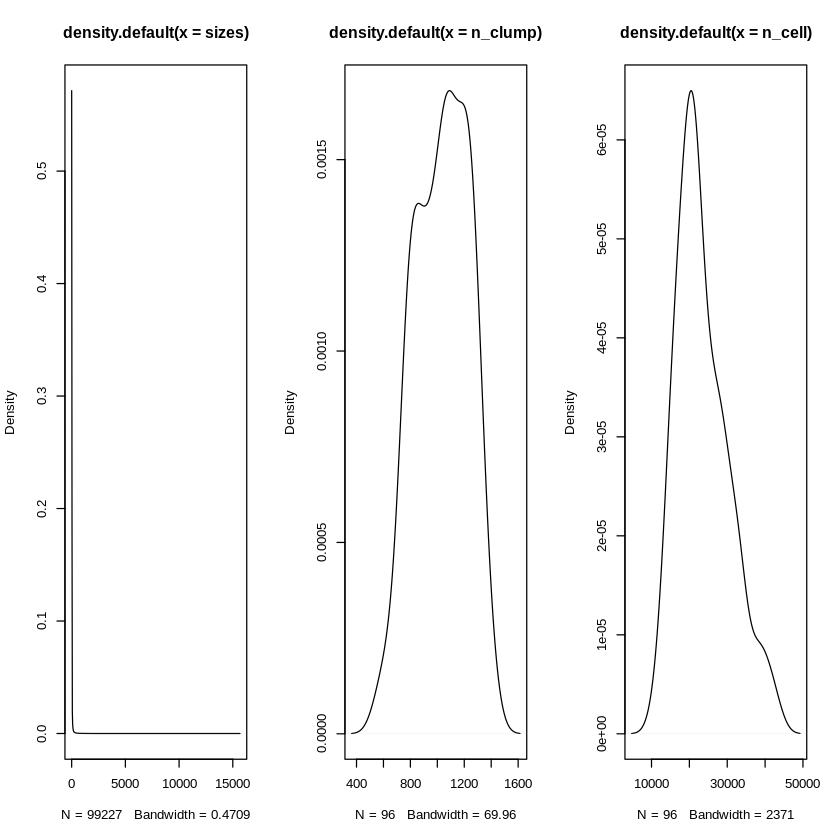

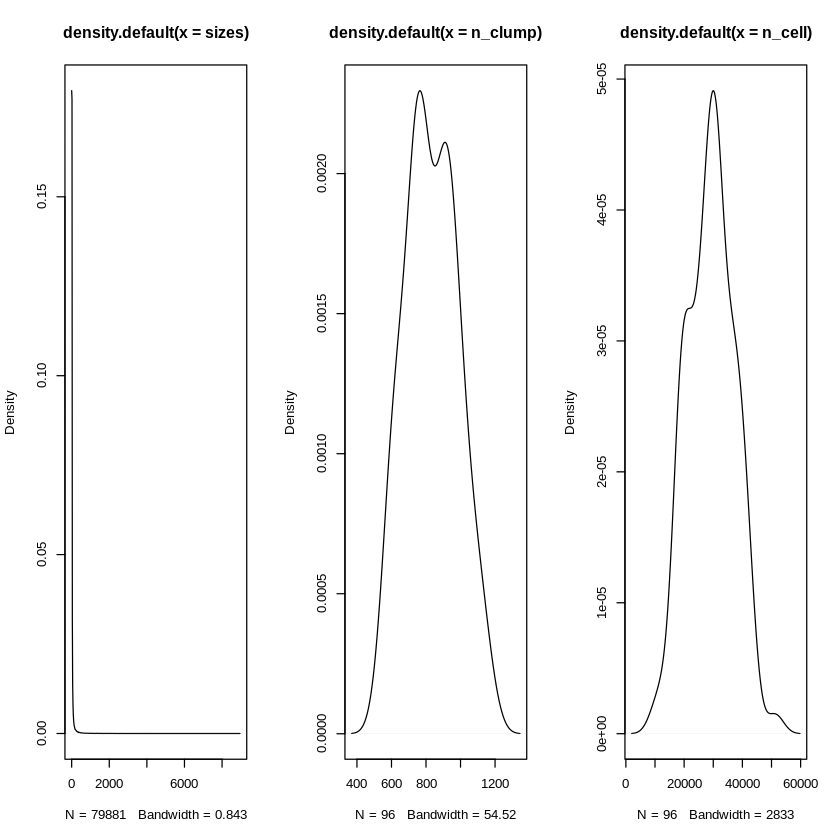

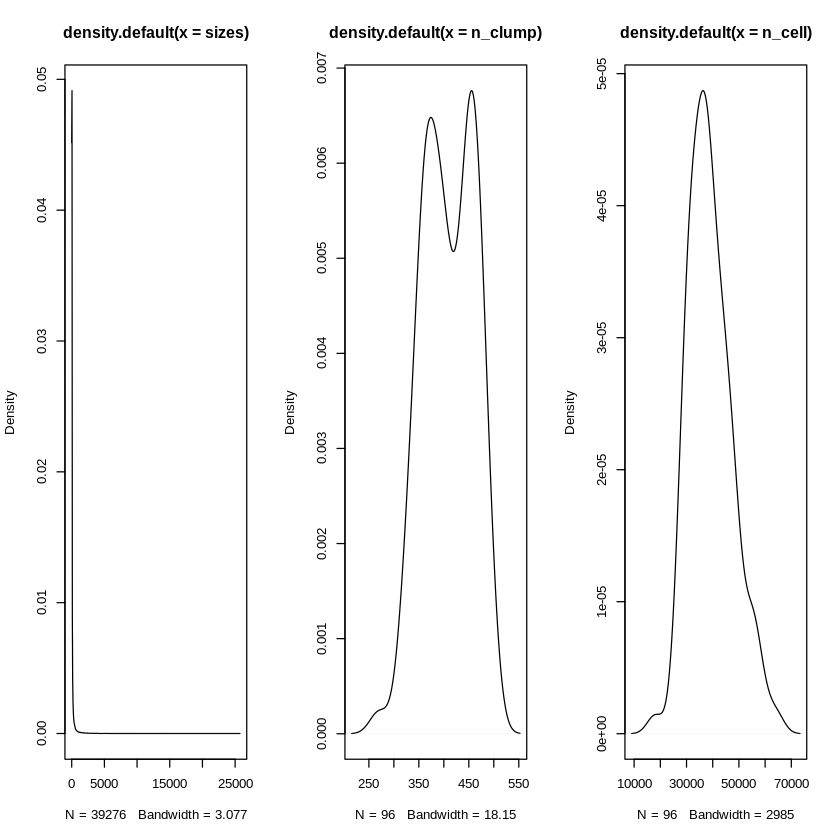

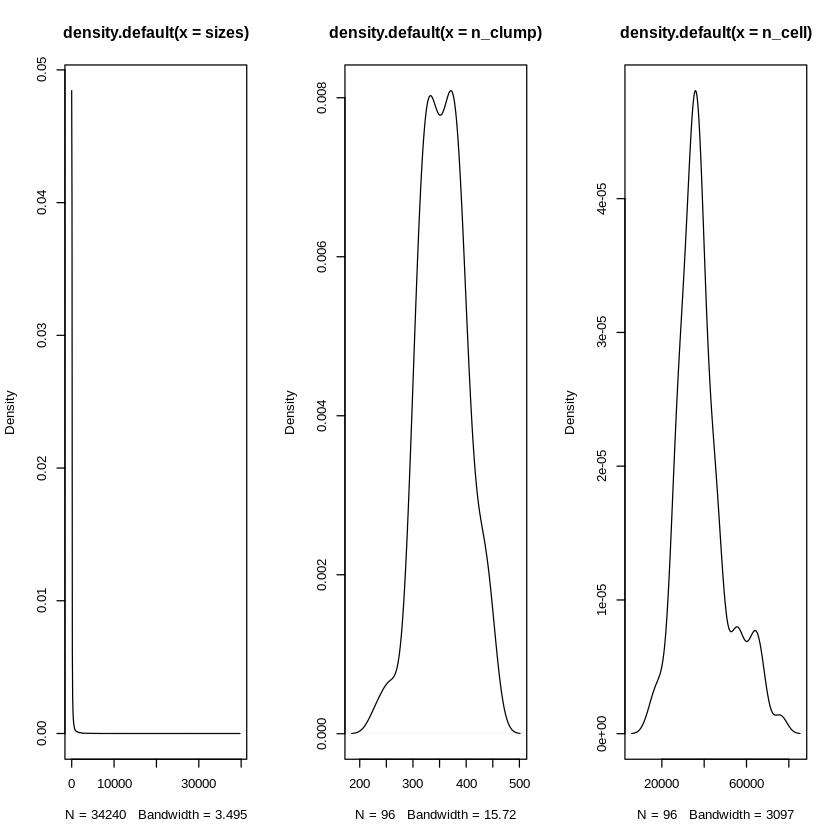

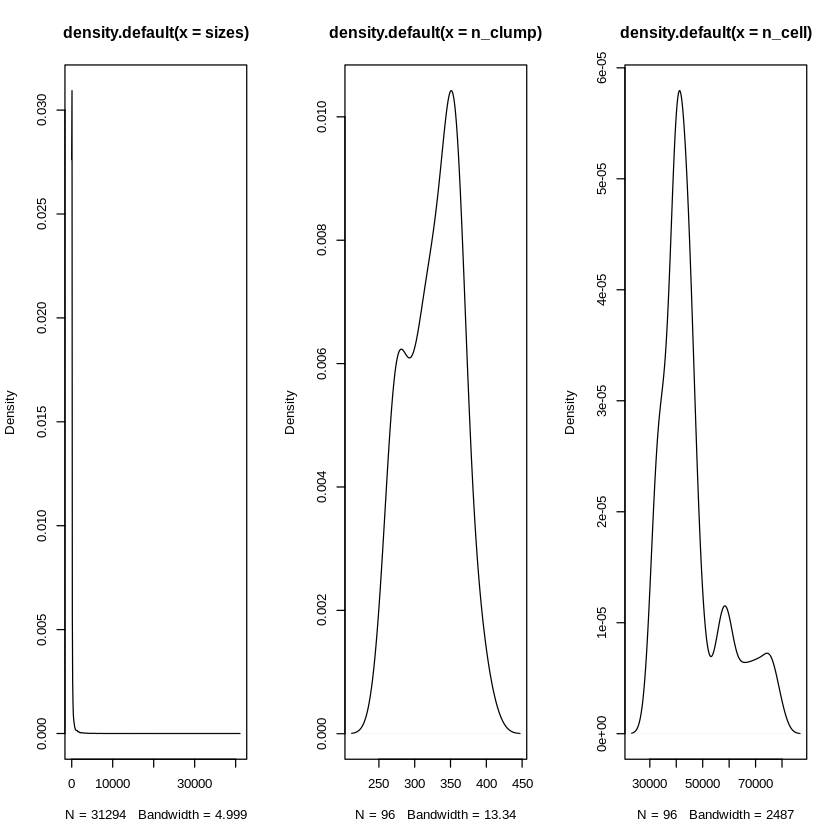

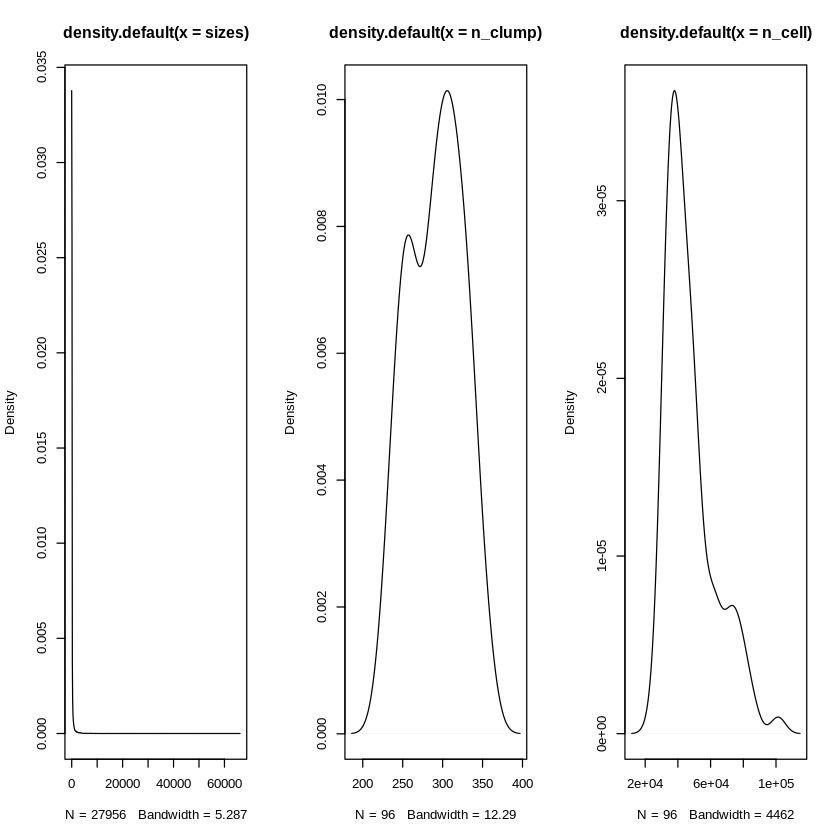

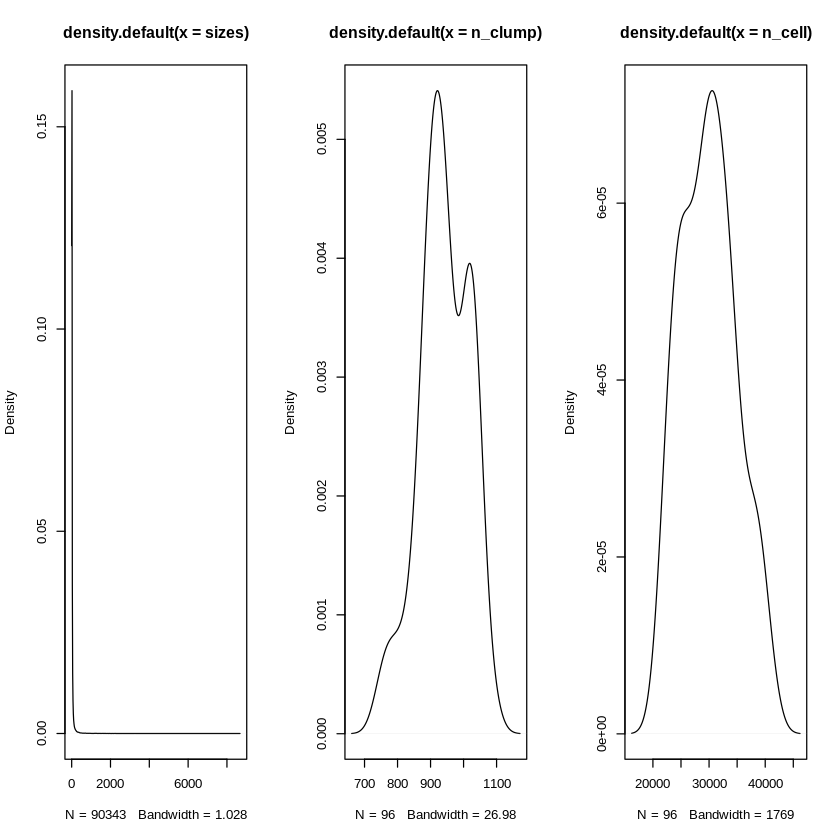

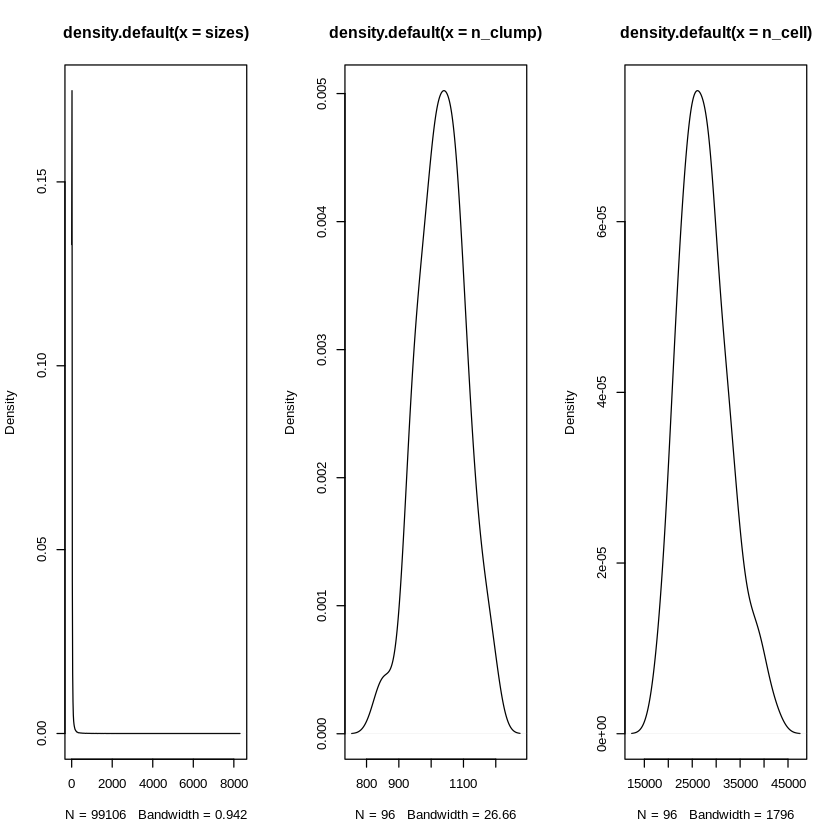

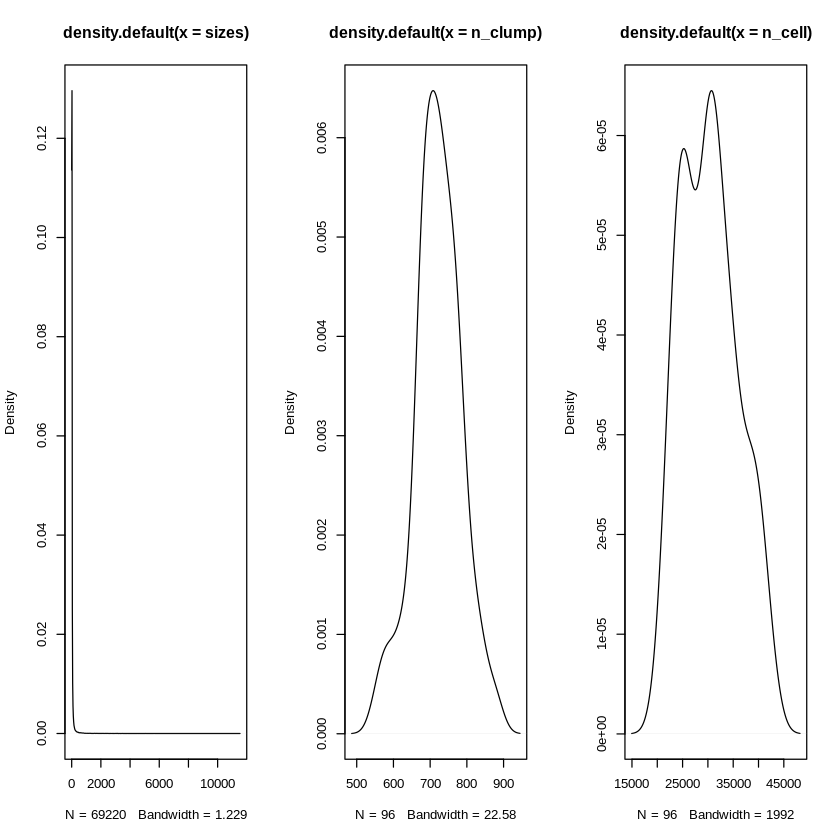

,n_cell,n_clump,clump_size
Min.,11875.00,574.000,3.00000
1st Qu.,19110.25,874.250,3.00000
Median,22050.50,1052.500,5.00000
Mean,23587.89,1033.615,22.82077
3rd Qu.,27903.75,1199.750,10.00000
Max.,42108.00,1404.000,15670.00000
,n_cell,n_clump,clump_size
Min.,10494.00,533.0000,3.00000
1st Qu.,23254.75,728.7500,4.00000
Median,29522.50,816.0000,7.00000


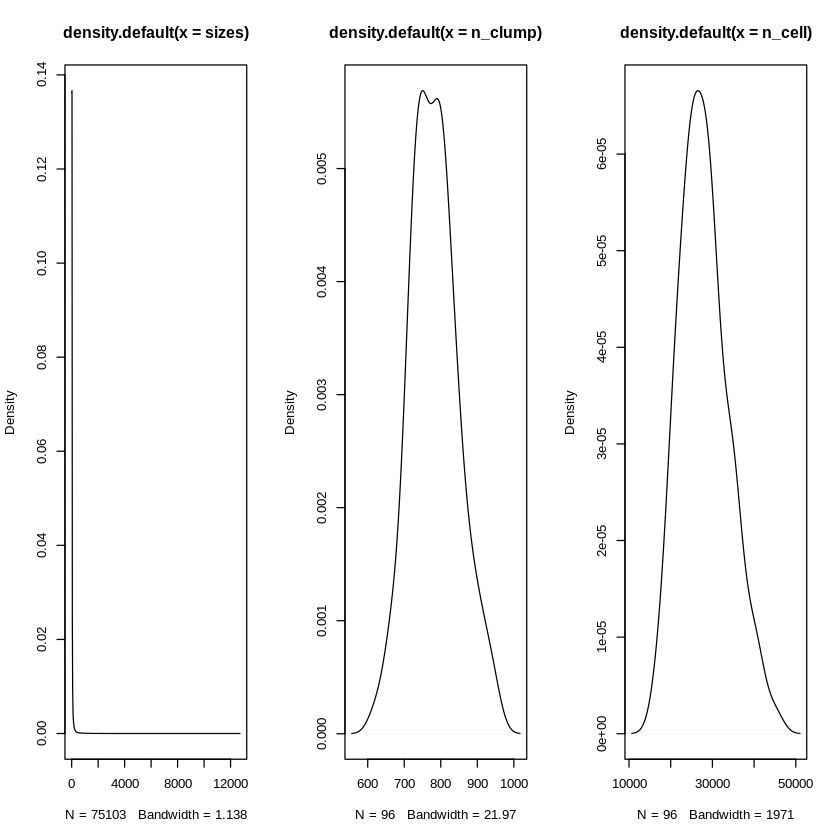

In [7]:
clump_sum <- function(stack) {
    sizes <- vector()
    n_clump <- rep(NA, nlayers(stack))
    n_cell <- rep(NA, nlayers(stack))
    for (i in 1:nlayers(stack)) {
        val <- values(stack[[i]])
        sizes <- c(sizes, table(val))
        n_clump[i] <- length(unique(stack[[i]]))
        n_cell[i] <- sum(!is.na(val))
    }
    ret <- cbind(summary(n_cell), summary(n_clump), summary(sizes))
    colnames(ret) <- c("n_cell", "n_clump", "clump_size")
    return(ret)
}
lapply(clumps, clump_sum) # takes a few minutes

### Investigating transactions

Once we have produced the drought clump list, we can produce a list of co-occurring droughts (transactions) for association rule mining and statistical analysis. 

In [ ]:
ncores <- 10
system.time( transactions <- transactions_from_clumps(clumps, ncores) )
# takes ~4-5h

names(transactions) <- names

In [9]:
# save/load transaction list

#save(transactions, file="transactions_clumps.RData")
#load(file="transactions_clumps.RData")

The transaction list is a tibble with drought indices as columns, and drought events as rows. Each event records a *TRUE* or *FALSE* for each drought type if they occur in said event. Below we compute the pairwise occurrence of drought indices in the transaction list. The table has values in percentages from the total transaction list; for instance we can find that SSI3 occurs in 43.9 % of the drought events, and that SSI3 and SPI3 are both occurring together in 12.9 % of drought events. 

In [22]:
mat <- matrix(NA, nrow=10, ncol=10)

for(i in 1:10) {
    for(j in 1:10) {
        mat[i,j] <- sum(transactions[,i] & transactions[,j]) / nrow(transactions)
    }
}
colnames(mat) <- names
rownames(mat) <- names
round(mat*100,2)

,fAPAR,SMDI,SPEI12,SPEI3,SPI12,SPI3,SRI12,SRI3,SSI12,SSI3
fAPAR,30.09,11.58,11.56,10.23,12.05,11.51,12.97,13.03,12.09,12.15
SMDI,11.58,31.66,13.25,12.68,13.65,13.94,14.69,14.58,13.63,13.53
SPEI12,11.56,13.25,31.50,17.14,25.02,17.17,14.00,14.27,12.78,13.14
SPEI3,10.23,12.68,17.14,29.36,15.57,22.41,13.68,13.70,12.60,12.68
SPI12,12.05,13.65,25.02,15.57,31.28,17.67,14.39,14.75,13.14,13.57
SPI3,11.51,13.94,17.17,22.41,17.67,29.63,14.02,13.97,12.89,12.86
SRI12,12.97,14.69,14.00,13.68,14.39,14.02,48.07,29.75,40.62,27.11
SRI3,13.03,14.58,14.27,13.70,14.75,13.97,29.75,48.73,27.08,41.07
SSI12,12.09,13.63,12.78,12.60,13.14,12.89,40.62,27.08,43.24,26.14
SSI3,12.15,13.53,13.14,12.68,13.57,12.86,27.11,41.07,26.14,43.93


We also analyse the similarity of the drought indices using Jaccard coefficient (standard correlation coefficients will not do because our data is not dichotomous). 

In [12]:
jaccard <- matrix(NA, nrow=10, ncol=10)
temp <- as.matrix(transactions)
for(i in 1:10) {
    for(j in 1:10) {
        jaccard[i,j] <- sum(temp[,i] & temp[,j]) / sum(temp[,i] | temp[,j])
    }
}
colnames(jaccard) <- names
rownames(jaccard) <- names
round(jaccard,2)

,fAPAR,SMDI,SPEI12,SPEI3,SPI12,SPI3,SRI12,SRI3,SSI12,SSI3
fAPAR,1.00,0.23,0.24,0.22,0.26,0.25,0.04,0.04,0.04,0.04
SMDI,0.23,1.00,0.28,0.28,0.29,0.31,0.05,0.05,0.05,0.05
SPEI12,0.24,0.28,1.00,0.43,0.69,0.42,0.06,0.05,0.06,0.05
SPEI3,0.22,0.28,0.43,1.00,0.38,0.63,0.06,0.05,0.06,0.05
SPI12,0.26,0.29,0.69,0.38,1.00,0.44,0.06,0.05,0.06,0.05
SPI3,0.25,0.31,0.42,0.63,0.44,1.00,0.05,0.05,0.05,0.05
SRI12,0.04,0.05,0.06,0.06,0.06,0.05,1.00,0.45,0.81,0.42
SRI3,0.04,0.05,0.05,0.05,0.05,0.05,0.45,1.00,0.42,0.80
SSI12,0.04,0.05,0.06,0.06,0.06,0.05,0.81,0.42,1.00,0.43
SSI3,0.04,0.05,0.05,0.05,0.05,0.05,0.42,0.80,0.43,1.00


We can also summarize how many drought types are co-occurring in the same drought event.

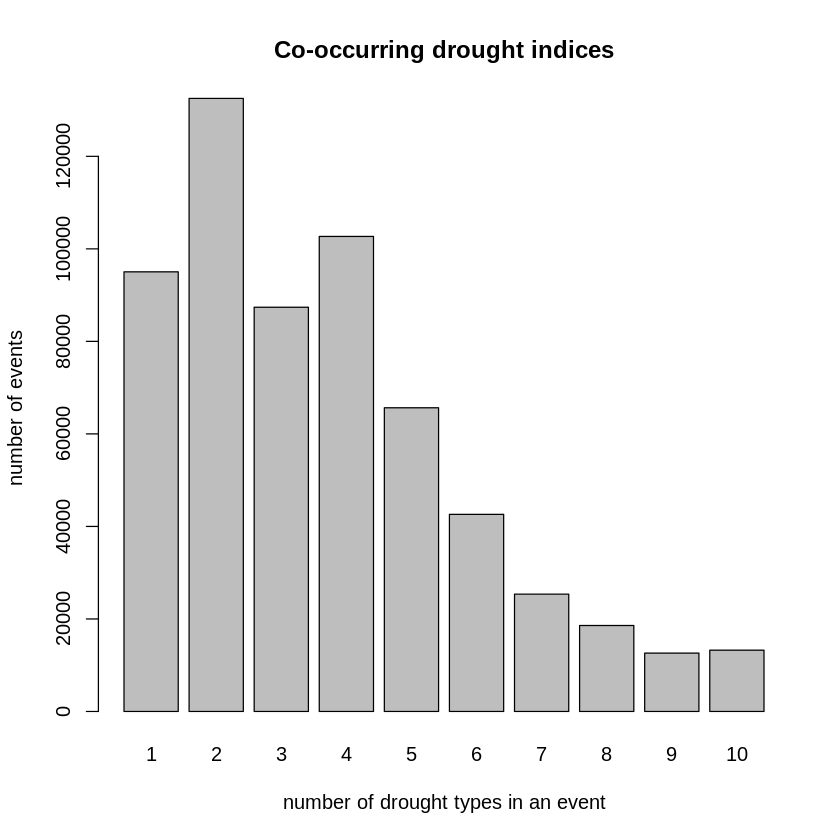

In [30]:
barplot(table(apply(transactions, 1, sum)), 
        main="Co-occurring drought indices", 
        ylab="number of events", 
        xlab="number of drought types in an event")

Pairwise chi-squared tests are performed to verify that the drought indices are not independent:

In [31]:
chisq <- matrix(NA, nrow=10, ncol=10)
for(i in 1:10){
    for( j in 1:10) {
        tbl <- table(transactions[,c(i,j)])
        temp <- chisq.test(tbl)
        chisq[i,j] <- temp$statistic
    }
}
colnames(chisq) <- names
rownames(chisq) <- names
round(chisq,2)

chisq_p <- matrix(NA, nrow=10, ncol=10)
for(i in 1:10){
    for( j in 1:10) {
        tbl <- table(transactions[,c(i,j)])
        temp <- chisq.test(tbl)
        chisq_p[i,j] <- temp$p.value
    }
}
colnames(chisq_p) <- names
rownames(chisq_p) <- names
round(chisq_p,3)

,fAPAR,SMDI,SPEI12,SPEI3,SPI12,SPI3,SRI12,SRI3,SSI12,SSI3
fAPAR,595710.25,5527.80,5672.44,2635.21,9155.98,9138.62,2544.85,3029.79,982.74,1325.56
SMDI,5527.80,595710.38,13691.14,15156.41,18032.76,27470.58,313.53,790.96,3.92,156.98
SPEI12,5672.44,13691.14,595710.37,82938.56,295561.12,81232.69,1438.41,1292.33,799.24,545.86
SPEI3,2635.21,15156.41,82938.56,595710.18,54441.28,258873.13,215.62,433.33,11.60,54.60
SPI12,9155.98,18032.76,295561.12,54441.28,595710.35,93903.60,461.58,266.82,168.94,31.24
SPI3,9138.62,27470.58,81232.69,258873.13,93903.60,595710.20,57.55,250.08,7.33,27.85
SRI12,2544.85,313.53,1438.41,215.62,461.58,57.55,595710.99,38161.95,382665.45,34811.56
SRI3,3029.79,790.96,1292.33,433.33,266.82,250.08,38161.95,595711.00,35083.18,374099.05
SSI12,982.74,3.92,799.24,11.60,168.94,7.33,382665.45,35083.18,595710.93,50297.82
SSI3,1325.56,156.98,545.86,54.60,31.24,27.85,34811.56,374099.05,50297.82,595710.94


,fAPAR,SMDI,SPEI12,SPEI3,SPI12,SPI3,SRI12,SRI3,SSI12,SSI3
fAPAR,0,0.000,0,0.000,0,0.000,0,0,0.000,0
SMDI,0,0.000,0,0.000,0,0.000,0,0,0.048,0
SPEI12,0,0.000,0,0.000,0,0.000,0,0,0.000,0
SPEI3,0,0.000,0,0.000,0,0.000,0,0,0.001,0
SPI12,0,0.000,0,0.000,0,0.000,0,0,0.000,0
SPI3,0,0.000,0,0.000,0,0.000,0,0,0.007,0
SRI12,0,0.000,0,0.000,0,0.000,0,0,0.000,0
SRI3,0,0.000,0,0.000,0,0.000,0,0,0.000,0
SSI12,0,0.048,0,0.001,0,0.007,0,0,0.000,0
SSI3,0,0.000,0,0.000,0,0.000,0,0,0.000,0


## Association rule mining

Next we run apriori algorithm to see if we can find interesting associations between the drought indices. Running the algorithm with minimum support of 10% and confidence of 30%, we get 186 rules with a maximum rule size of 4 types. 

In [24]:
trans <- as(transactions, "transactions") # create transactions for apriori
trans

rules <- apriori (trans, parameter = list(supp = 0.1, conf = 0.3)) # run algorithm
summary(rules)

transactions in sparse format with
 595715 transactions (rows) and
 10 items (columns)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 59571 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[10 item(s), 595715 transaction(s)] done [0.16s].
sorting and recoding items ... [10 item(s)] done [0.02s].
creating transaction tree ... done [0.40s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [186 rule(s)] done [0.00s].
creating S4 object  ... done [0.10s].


set of 186 rules

rule length distribution (lhs + rhs):sizes
 1  2  3  4 
 8 72 90 16 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   2.613   3.000   4.000 

summary of quality measures:
    support         confidence          lift            count       
 Min.   :0.1001   Min.   :0.3009   Min.   :0.8885   Min.   : 59628  
 1st Qu.:0.1156   1st Qu.:0.4332   1st Qu.:1.0049   1st Qu.: 68862  
 Median :0.1288   Median :0.6207   Median :1.8391   Median : 76708  
 Mean   :0.1621   Mean   :0.6457   Mean   :1.7179   Mean   : 96579  
 3rd Qu.:0.1557   3rd Qu.:0.8687   3rd Qu.:2.0333   3rd Qu.: 92734  
 Max.   :0.4873   Max.   :0.9695   Max.   :3.0340   Max.   :290299  

mining info:
  data ntransactions support confidence
 trans        595715     0.1        0.3

### list all the rules

In [32]:
sort <- "lift" # sort list by to support, confidence, or lift
rules <- sort(rules, by=sort, decreasing=TRUE)
inspect(rules)

      lhs                     rhs      support   confidence lift      count 
[1]   {SPEI12,SPEI3,SPI12} => {SPI3}   0.1266327 0.8990228  3.0340325  75437
[2]   {SPEI3,SPI12}        => {SPI3}   0.1395097 0.8961977  3.0244985  83108
[3]   {SMDI,SPEI3}         => {SPI3}   0.1089061 0.8591273  2.8993929  64877
[4]   {SPEI3,SPI12,SPI3}   => {SPEI12} 0.1266327 0.9076984  2.8813401  75437
[5]   {SPEI3,SPI12}        => {SPEI12} 0.1408559 0.9048461  2.8722859  83910
[6]   {SPEI12,SPEI3,SPI3}  => {SPI12}  0.1266327 0.8899336  2.8455090  75437
[7]   {SPEI12,SPI3}        => {SPI12}  0.1526132 0.8889606  2.8423979  90914
[8]   {SPEI12,SPI12,SPI3}  => {SPEI3}  0.1266327 0.8297622  2.8257281  75437
[9]   {fAPAR,SPEI12}       => {SPI12}  0.1020555 0.8828672  2.8229146  60796
[10]  {SPEI12,SPI3}        => {SPEI3}  0.1422946 0.8288550  2.8226386  84767
[11]  {SPEI12,SPEI3}       => {SPI3}   0.1422946 0.8299668  2.8009816  84767
[12]  {SMDI,SPEI12}        => {SPI12}  0.1147461 0.8660113  2.7690188  68356

The entire list of all of the rules is difficult to read. By changing the chunk below we can pick rules which lead to a certain drought index  as the consequent (*RHS, right hand side of the rule*). In the example below, we inspect all the rules which have *SSI12* as consequent index. 

In [35]:
RHS <- "SSI12"
sort <- "lift"

rules_sub <- apriori (trans, parameter = list(supp = 0.1, conf = 0.3), appearance = list(default = "lhs", rhs = RHS)) 
rules_sub <- sort(rules_sub, by=sort, decreasing=TRUE)
inspect(rules_sub)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 59571 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[10 item(s), 595715 transaction(s)] done [0.16s].
sorting and recoding items ... [10 item(s)] done [0.02s].
creating transaction tree ... done [0.36s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [22 rule(s)] done [0.00s].
creating S4 object  ... done [0.09s].
     lhs                     rhs     support   confidence lift      count 
[1]  {SRI12,SRI3,SSI3}    => {SSI12} 0.2411640 0.9267633  2.1434022 143665
[2]  {SRI12,SSI3}         => {SSI12} 0.2500407 0.9222411  2.1329432 148953
[3]  {SMDI,SRI12}         => {SSI12} 0.1292934 0.8803219